In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tree-counting-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3590975%2F6248866%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240226%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240226T114129Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da9e310441d2b64b386b0c7914ce4079f1b3b3c41b7d18026c46ab0a3261d423562886dde18769ab058f8998d81b22c4c9e5a69f7c71e6ccafbb036c47d5e78cc6d51e134e711407f24ddc4bdb992ef8b70c9a1c2f1538d86298c7b42ce6bacae5517bf4da1fb8f848baea39f0ce0945d36181eb73a2c5516c3edc9bf36c757b542ee8b56a02d291a0694c7cdeeeada23521ae2c23eb02a50f9096a54283e73e2c7858bfdcee6c725866305df99b8ed517fca9e88a47f945243ae84cbf841fbe2468c1e5ee62c7fd6dbe0edba8847454b3cfb5edbf1dd22fb503d5a2e2a35c4fc37994b4a5c39700168857b93a3e03bf2235dc6483515b82d40f68760aa146efe'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7936473 bytes downloaded
Downloaded and uncompressed: tree-counting-image-dataset
Data source import complete.


# Summary

This notebook demonstrates how to count trees by learning their density maps.

The inspiration comes from the paper "[Tree counting with high spatial-resolution satellite imagery based on deep neural networks](https://www.sciencedirect.com/science/article/pii/S1470160X21002569)", *Ecological Indicators* (2021).

# Dataset

We will use available annotations (bounding boxes) to obtain density maps of the trees. We can think of them as heatmaps.

More precisely, bounding boxes are used to distribute the mass of every tree according to rectangular kernels.

In [11]:
import numpy as np
import tensorflow as tf
from glob import glob

IMG_SIZE = (256,256)

def gen_example(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    label_wh = labels[:,[3,4]]
    label_xy = labels[:,[1,2]]
    boxes = np.hstack([label_xy-0.5*label_wh,label_xy+0.5*label_wh])
    boxes = boxes*(img.shape[:2]+img.shape[:2])
    K_loc = 0.5*(boxes[:,[2,3]]+boxes[:,[0,1]])
    K_bw = 0.5*(boxes[:,[2,3]]-boxes[:,[0,1]])
    ys, xs = np.ogrid[0:img.shape[0]:IMG_SIZE[0]*1j, 0:img.shape[1]:IMG_SIZE[1]*1j]
    dens = 0
    for (loc_x,loc_y),(bw_x,bw_y) in zip(K_loc,K_bw):
        bw_x, bw_y = 10,10 # use constant rather than actual size for simplicity
        dens_update = np.clip(1-np.abs(loc_x-xs)/bw_x,0,1)*np.clip(1-np.abs(loc_y-ys)/bw_y,0,1)
        # dens_update = dens_update * 1/dens_update.sum() # normalize
        dens = dens + dens_update
    return img,dens


def gen_data(subpath='train'):
    def gen():
        for img_path in glob(f'/kaggle/input/tree-counting-image-dataset/{subpath}/images/*.jpg'):
            img,dens = gen_example(img_path)
            yield img,dens
    return gen


train_ds = tf.data.Dataset.from_generator(
     gen_data('train'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
train_ds = train_ds.shuffle(100).batch(32).prefetch(1).cache()

val_ds = tf.data.Dataset.from_generator(
     gen_data('valid'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
val_ds = val_ds.shuffle(1000).batch(32).prefetch(1).cache()

test_ds = tf.data.Dataset.from_generator(
     gen_data('test'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
test_ds = test_ds.batch(32).prefetch(1).cache()

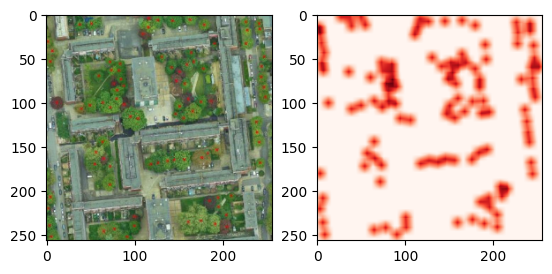

In [12]:
import matplotlib.pyplot as plt

img,dens = next(train_ds.unbatch().as_numpy_iterator())
fig,axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(dens,cmap="Reds")
plt.show()

# Model

Following the paper, we build a CNN model inspired by Alex-Net.

However, compared to the original paper, we will use larger filters, less neurons and maintain higher resolution of the density map (upsampling factor here is 4x rather than 8x).

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


def get_original_model():

    model = tf.keras.Sequential([

        layers.Conv2D(32,(5,5), input_shape=(256,256,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2),strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(64,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2), strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(256,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2),strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128,(1,1), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(1,(1,1), padding='same'),
        layers.Activation('relu'),

        layers.UpSampling2D(size=(8,8)),
        layers.Reshape((256,256)),
    ]
    )


    model.compile(optimizer=tf.keras.optimizers.Adam(1e-8),
                  loss=tf.keras.losses.MeanSquaredError(),)

    return model

model = get_original_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 activation_10 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 activation_11 (Activation)  (None, 128, 128, 64)      0         
                                                      

Epoch 1/500
2/2 [==============================] - 11s 2s/step - loss: 0.0661 - val_loss: 0.0656
Epoch 2/500
2/2 [==============================] - 0s 179ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 3/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 4/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 5/500
2/2 [==============================] - 0s 180ms/step - loss: 0.0661 - val_loss: 0.0656


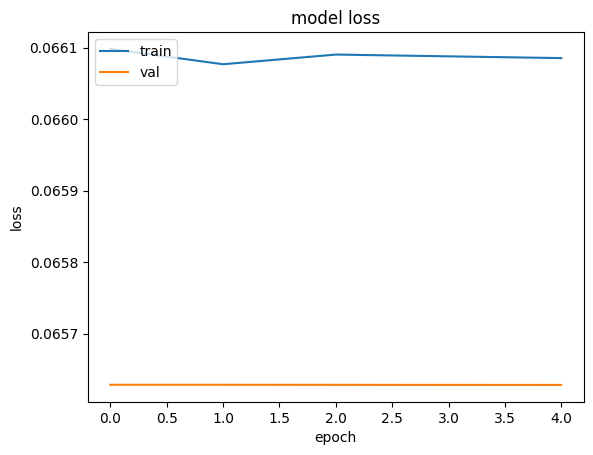

In [14]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,validation_data=val_ds,epochs=500,callbacks=[early_stopper])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 838ms/step


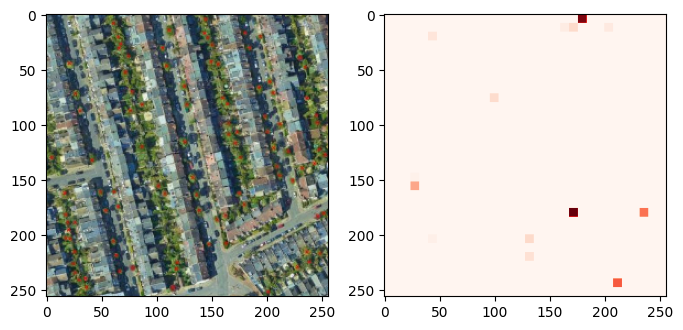

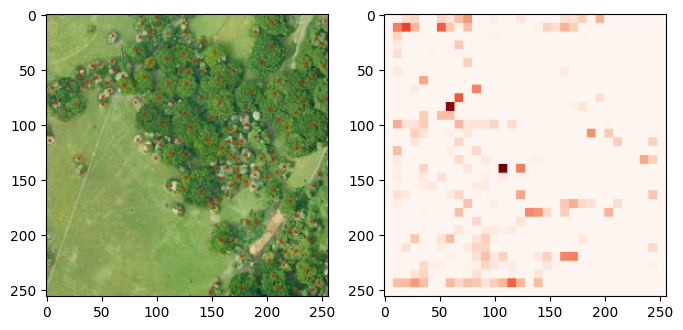

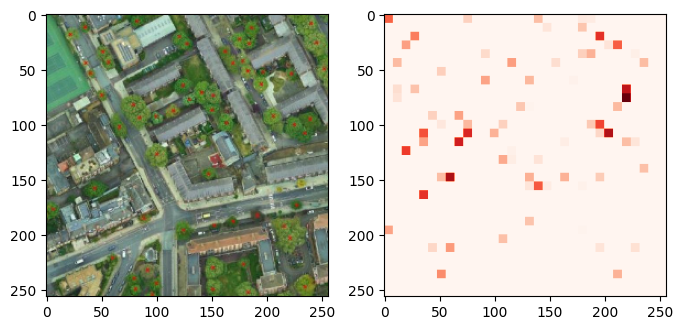

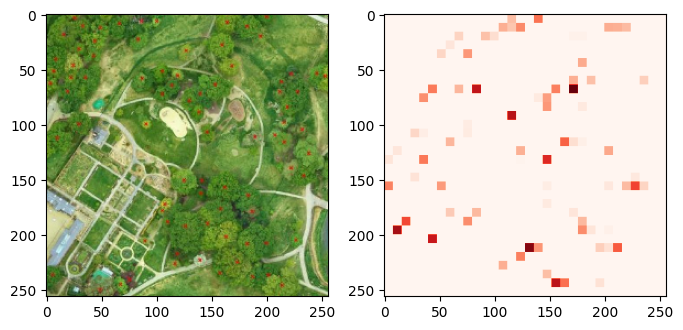

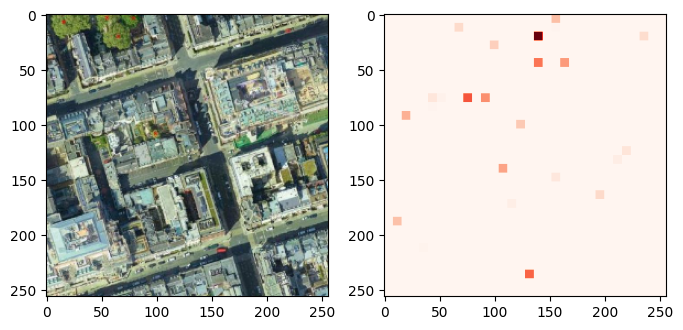

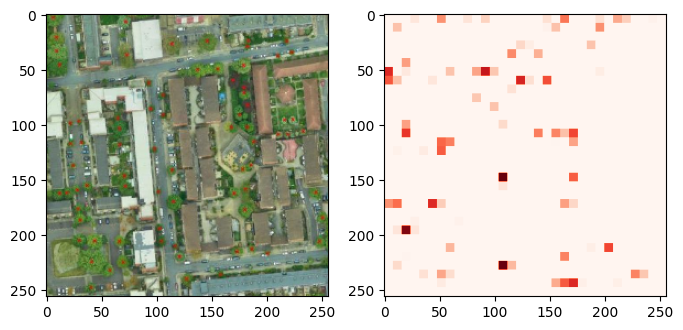

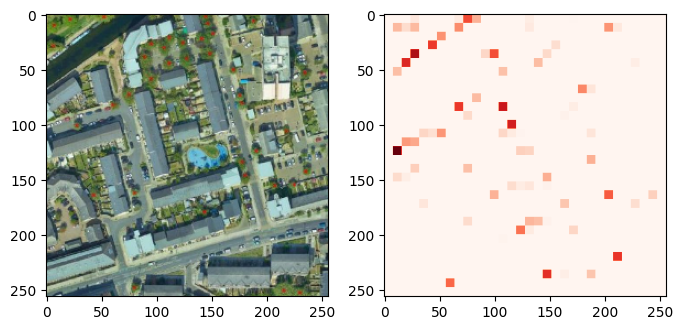

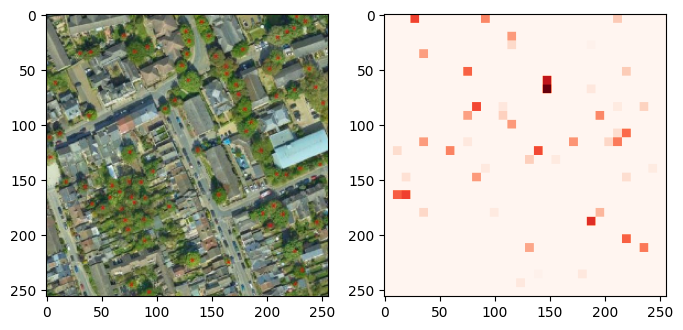

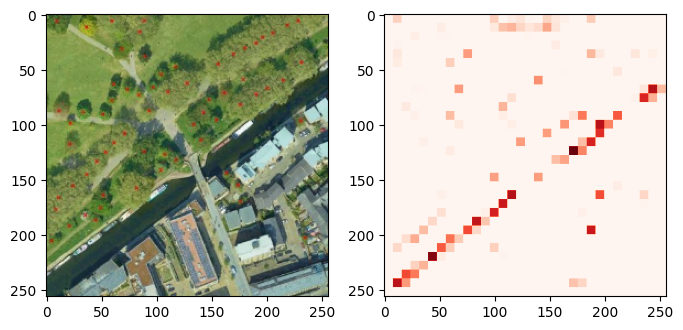

In [15]:
imgs_pred = model.predict(test_ds)
for img_pred,(img,_) in zip(imgs_pred,test_ds.unbatch().as_numpy_iterator()):
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(img)
    axs[1].imshow( img_pred, cmap="Reds" )
    plt.show()

In [20]:
from sklearn.metrics import r2_score

imgs_pred = model.predict(test_ds)
imgs_dens = np.stack( [dens for _,dens in test_ds.unbatch().as_numpy_iterator()] )
r2_score(imgs_pred.ravel(),imgs_dens.ravel())

1/1 [==============================] - 0s 22ms/step


-124497.4470806406

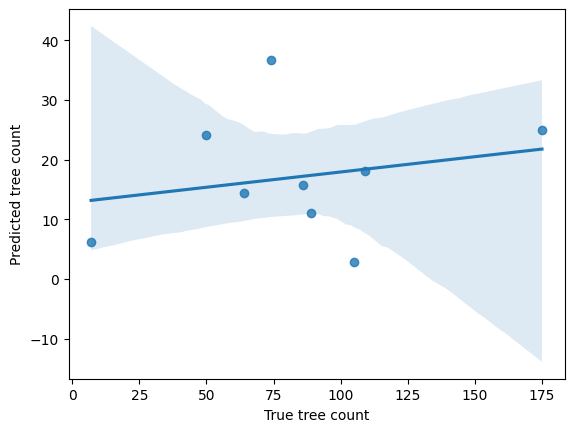

In [19]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

tree_cnt = []
subpath = 'test'
for img_path in glob(f'/kaggle/input/tree-counting-image-dataset/{subpath}/images/*.jpg'):
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    tree_cnt.append(len(labels))
tree_cnt = np.array(tree_cnt)

total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2]).numpy()
density_constant = LinearRegression().fit(total_dens_pred.reshape(-1,1),tree_cnt).coef_[0]
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2]).numpy()

fig,ax = plt.subplots()
sns.regplot(x=tree_cnt,y=total_dens_pred*density_constant,ax=ax)
ax.set_xlabel('True tree count')
ax.set_ylabel('Predicted tree count')
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

input_shape = IMG_SIZE + (3,)

def get_new_model():

    model = tf.keras.Sequential([

        layers.Conv2D(32,kernel_size=10, strides=1,input_shape=input_shape, padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=3,strides=2,padding='same'),

        layers.Conv2D(64,kernel_size=3, padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(64,kernel_size=3, padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=3,strides=2,padding='same'),

        layers.Conv2D(1,kernel_size=3, padding='same'),
        layers.Activation('relu'),

        layers.UpSampling2D(size=(4,4), interpolation='bilinear'),
    ]
    )


    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),)

    return model

model = get_new_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      9632      
                                                                 
 activation_16 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 activation_17 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 64)      36928     
                                                      

# Training

Epoch 1/500
2/2 [==============================] - 2s 325ms/step - loss: 0.0531 - val_loss: 0.0518
Epoch 2/500
2/2 [==============================] - 0s 133ms/step - loss: 0.0525 - val_loss: 0.0508
Epoch 3/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0516 - val_loss: 0.0506
Epoch 4/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0507 - val_loss: 0.0495
Epoch 5/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0498 - val_loss: 0.0489
Epoch 6/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0493 - val_loss: 0.0481
Epoch 7/500
2/2 [==============================] - 0s 128ms/step - loss: 0.0484 - val_loss: 0.0473
Epoch 8/500
2/2 [==============================] - 0s 135ms/step - loss: 0.0476 - val_loss: 0.0466
Epoch 9/500
2/2 [==============================] - 0s 133ms/step - loss: 0.0468 - val_loss: 0.0460
Epoch 10/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0461 - val_loss: 0.0454
Epoch 11/

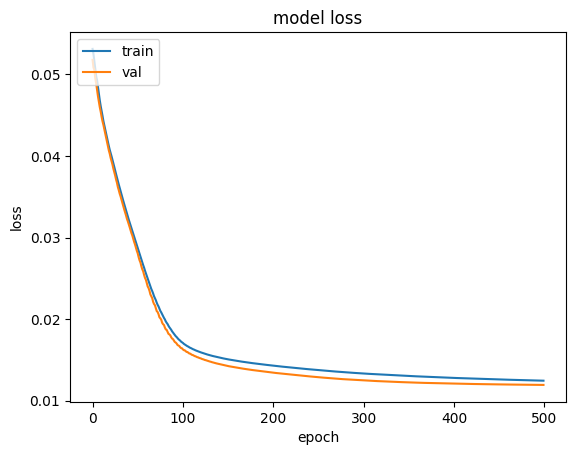

In [22]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,validation_data=val_ds,epochs=500,callbacks=[early_stopper])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Validation

We first visually confirm that the model is able to succesfuly locate the trees at unseen images.

1/1 [==============================] - 0s 68ms/step


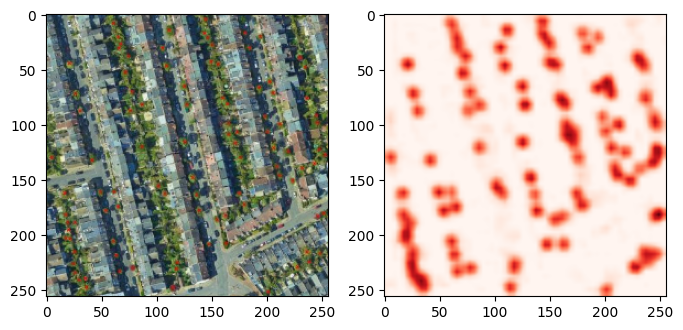

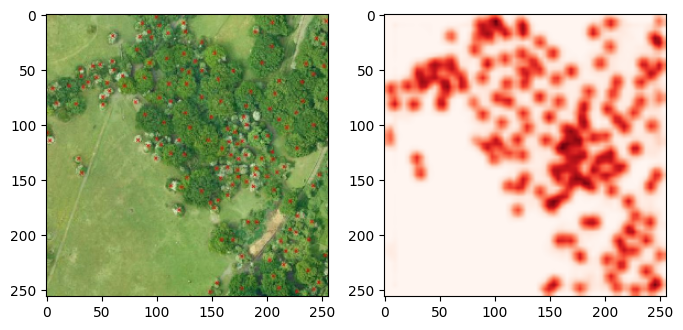

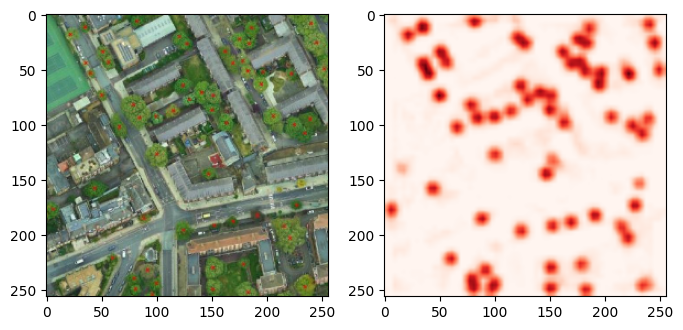

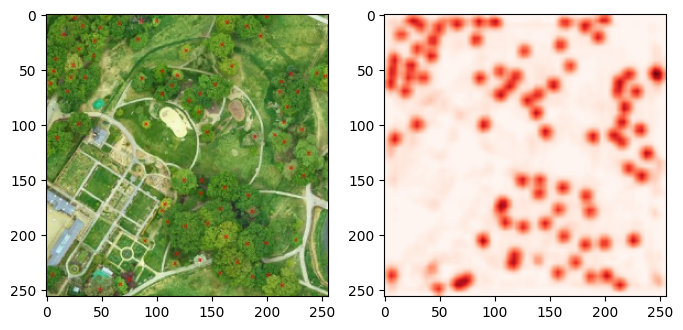

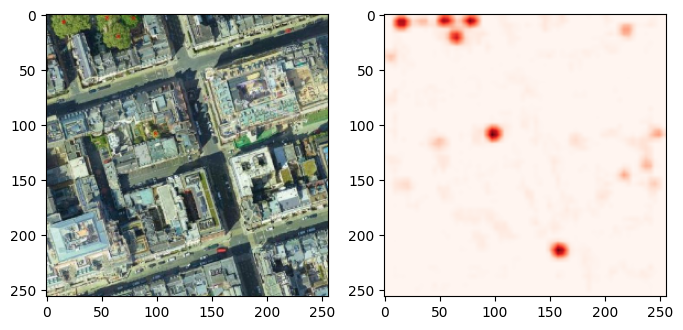

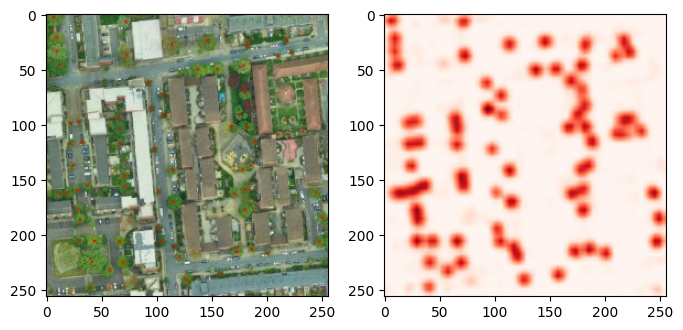

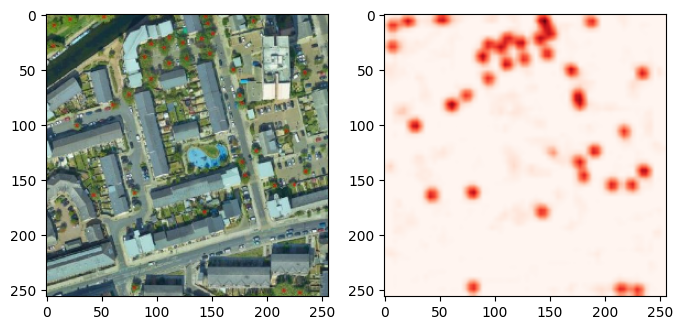

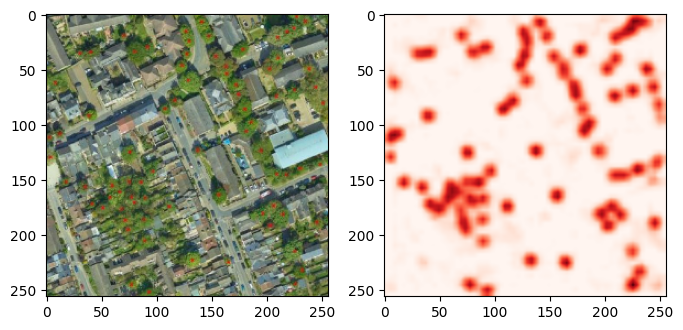

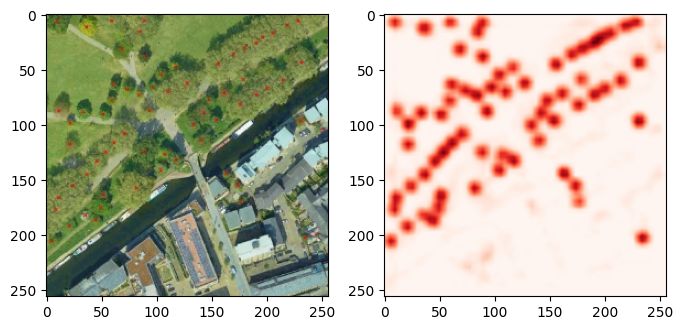

In [23]:
imgs_pred = model.predict(test_ds)
for img_pred,(img,_) in zip(imgs_pred,test_ds.unbatch().as_numpy_iterator()):
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(img)
    axs[1].imshow( img_pred, cmap="Reds" )
    plt.show()

The original publication reports pretty good r2 score for density maps on their dataset. This model leaves lots of room for improvement, but is not bad:

In [24]:
from sklearn.metrics import r2_score

imgs_pred = model.predict(test_ds)
imgs_dens = np.stack( [dens for _,dens in test_ds.unbatch().as_numpy_iterator()] )
r2_score(imgs_pred.ravel(),imgs_dens.ravel())

1/1 [==============================] - 0s 24ms/step


0.6796972433753554

Finally, the esimated number of trees is proportional to the total density (here this factor equals 0.01). We confirm that it matches well the actual number of trees.

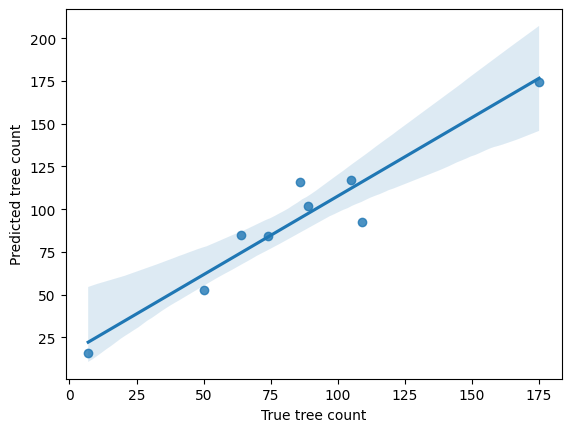

In [25]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

tree_cnt = []
subpath = 'test'
for img_path in glob(f'/kaggle/input/tree-counting-image-dataset/{subpath}/images/*.jpg'):
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    tree_cnt.append(len(labels))
tree_cnt = np.array(tree_cnt)

total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()
density_constant = LinearRegression().fit(total_dens_pred.reshape(-1,1),tree_cnt).coef_[0]
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()

fig,ax = plt.subplots()
sns.regplot(x=tree_cnt,y=total_dens_pred*density_constant,ax=ax)
ax.set_xlabel('True tree count')
ax.set_ylabel('Predicted tree count')
plt.show()